In [1]:
import sys
import os

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import anndata
import seaborn as sns
import torch
import matplotlib.font_manager
from matplotlib import rcParams
font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'
rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

%load_ext autoreload
%autoreload 2

sys.path.append('../')
import sample_squidiff

import plot_util 

import warnings
warnings.filterwarnings('ignore')

In [2]:
sampler = sample_squidiff.sampler(
    model_path = '../Squidiff_project/saved_model/fig2_model.pt',#'diff_results/model.pt',
    gene_size = 203,
    output_dim = 203,
    use_drug_structure = False
)

load model and diffusion...
diffusion num of steps =  1000


In [7]:
train_adata = sc.read_h5ad('datasets/diff_train.h5ad')
z_sem = sampler.model.encoder(
    torch.tensor(train_adata.X).to('cuda')
)

scrnas_pred = sampler.pred(z_sem, gene_size = train_adata.shape[1])
                
x_T = sampler.stochastic_encode(
    sampler.model,
    x = torch.tensor(train_adata.X, dtype = torch.float32).to('cuda'),
    t = 999,
    model_kwargs={'x_start':torch.tensor(train_adata.X, dtype = torch.float32).to('cuda'),
                  'z_mod':z_sem,
    }
)['sample']

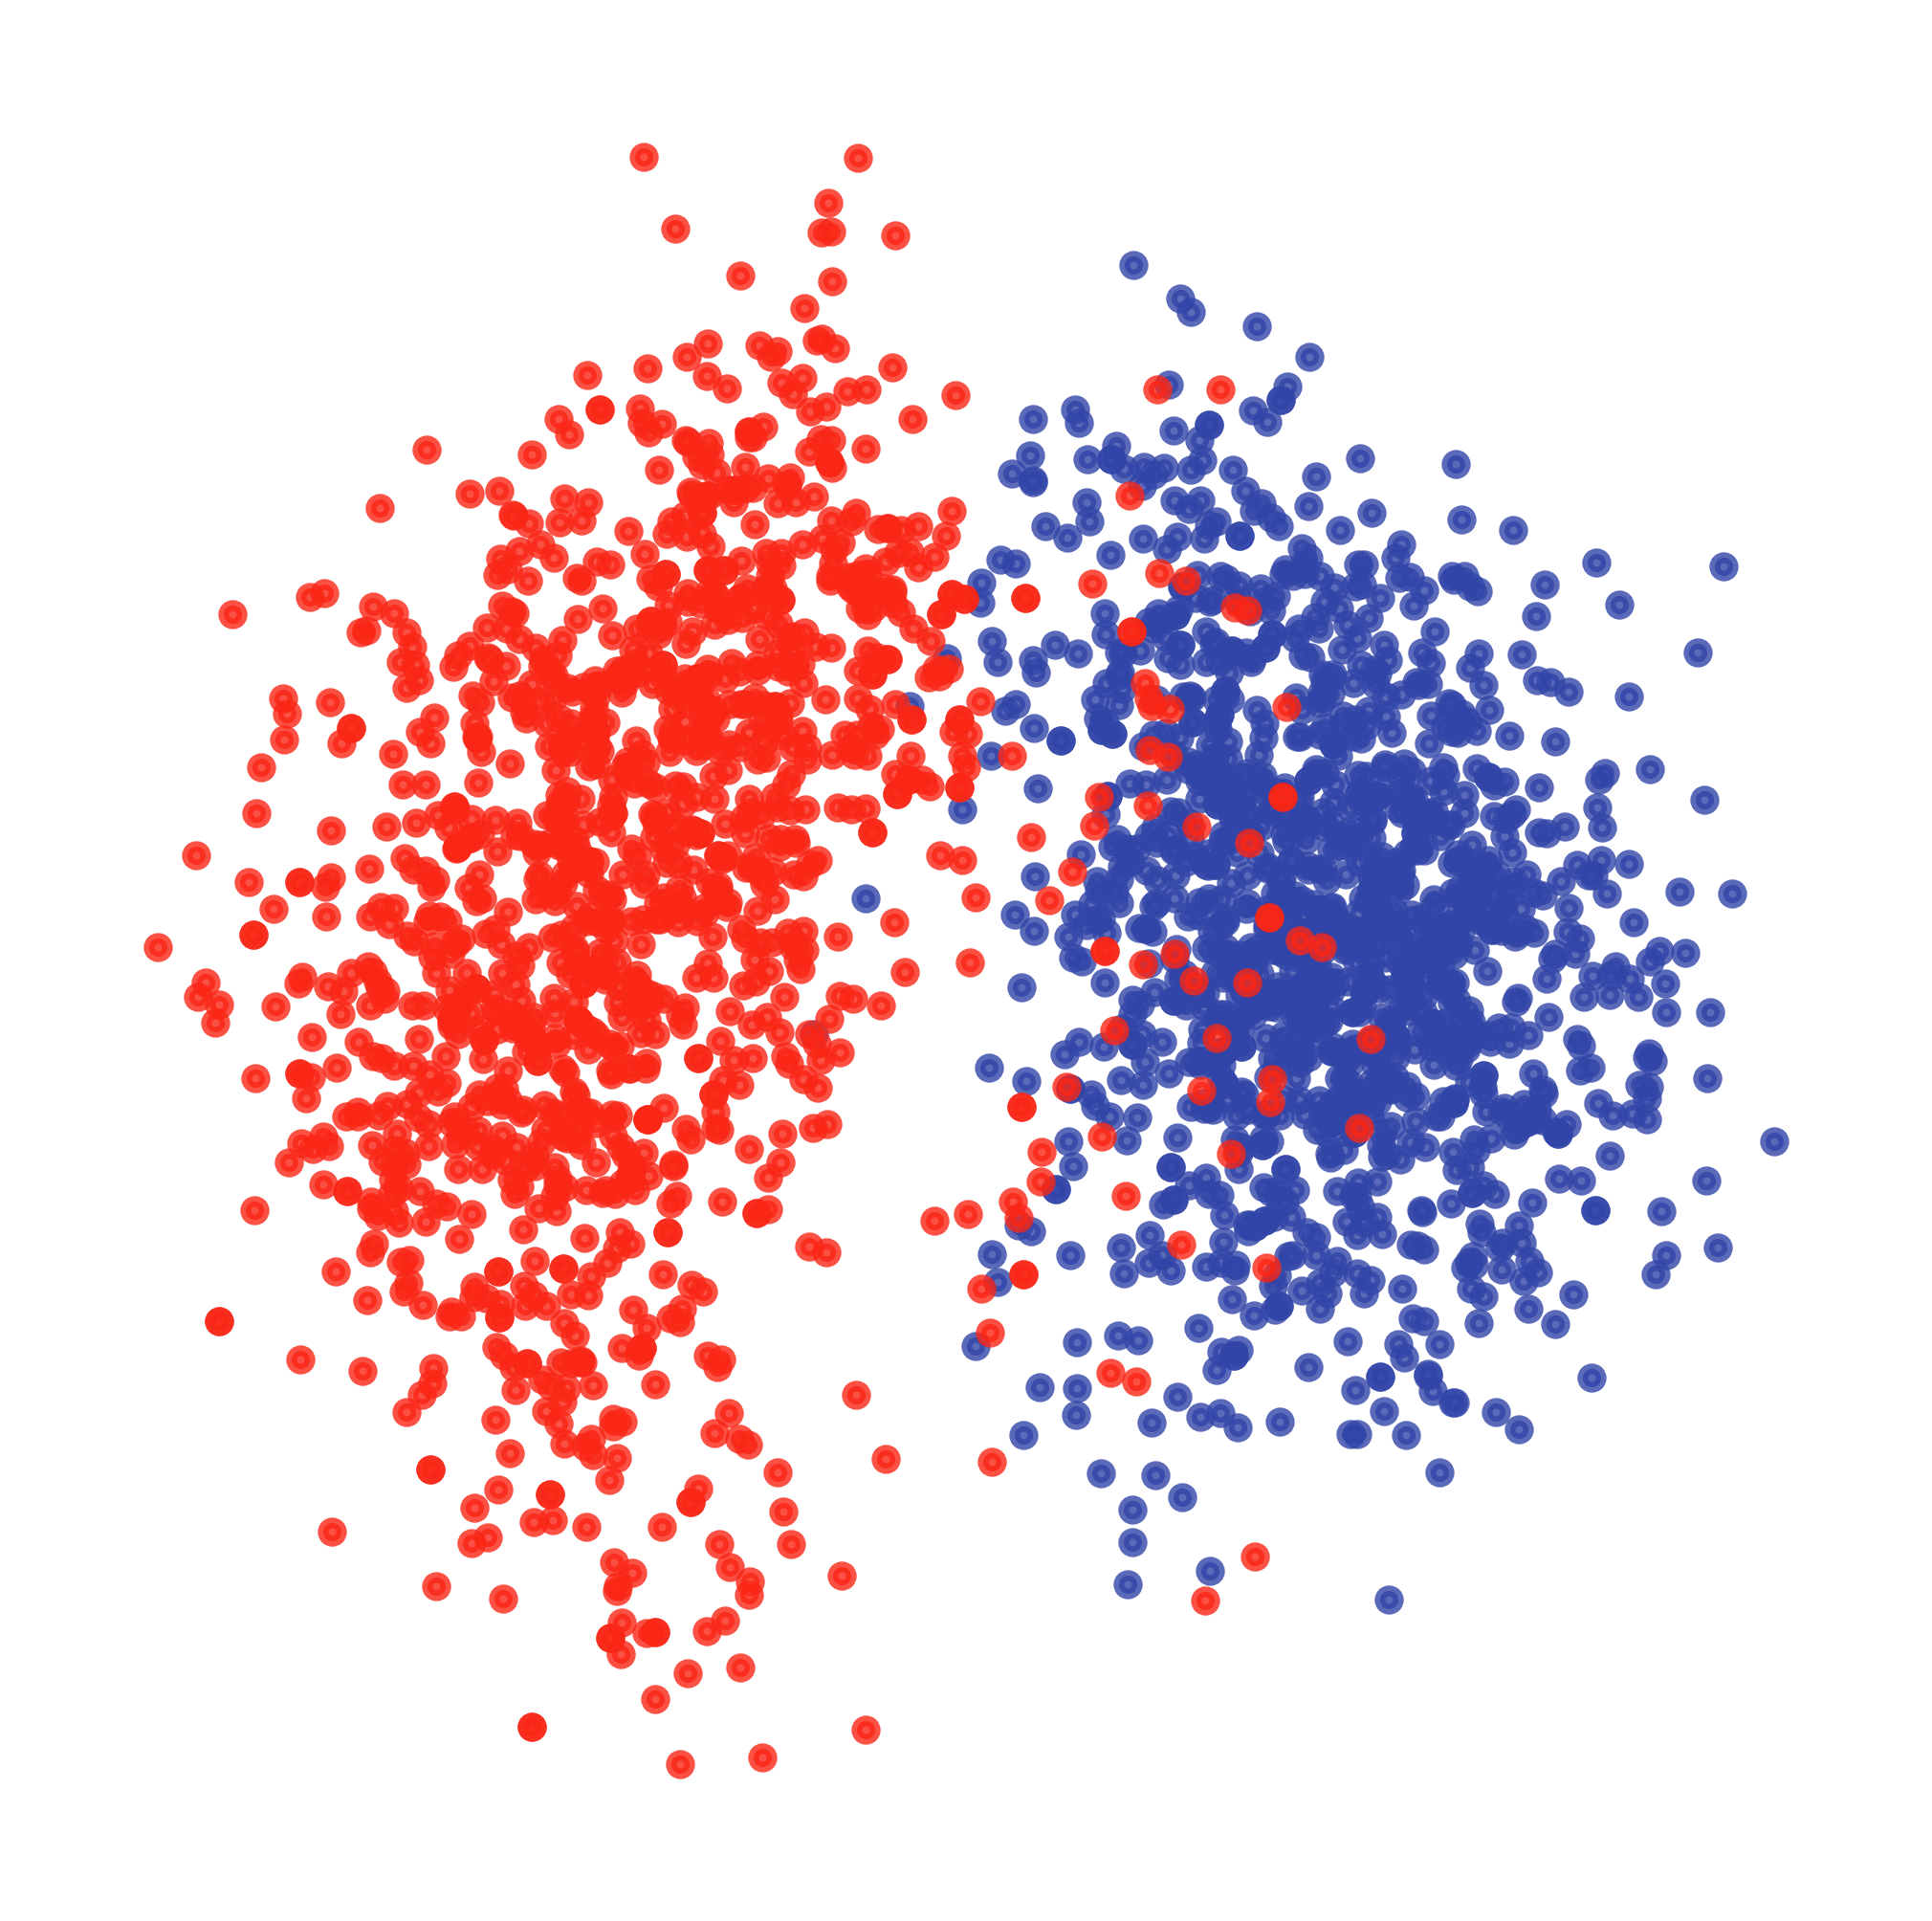

In [10]:
plot_util.plot_pca(z_sem,
                   label = train_adata.obs['Group'],
                   size = 3, alpha=0.8,
                   colorlist = ['#3145a8', '#fa2616'],
                   color_label=[0,3]
                  )

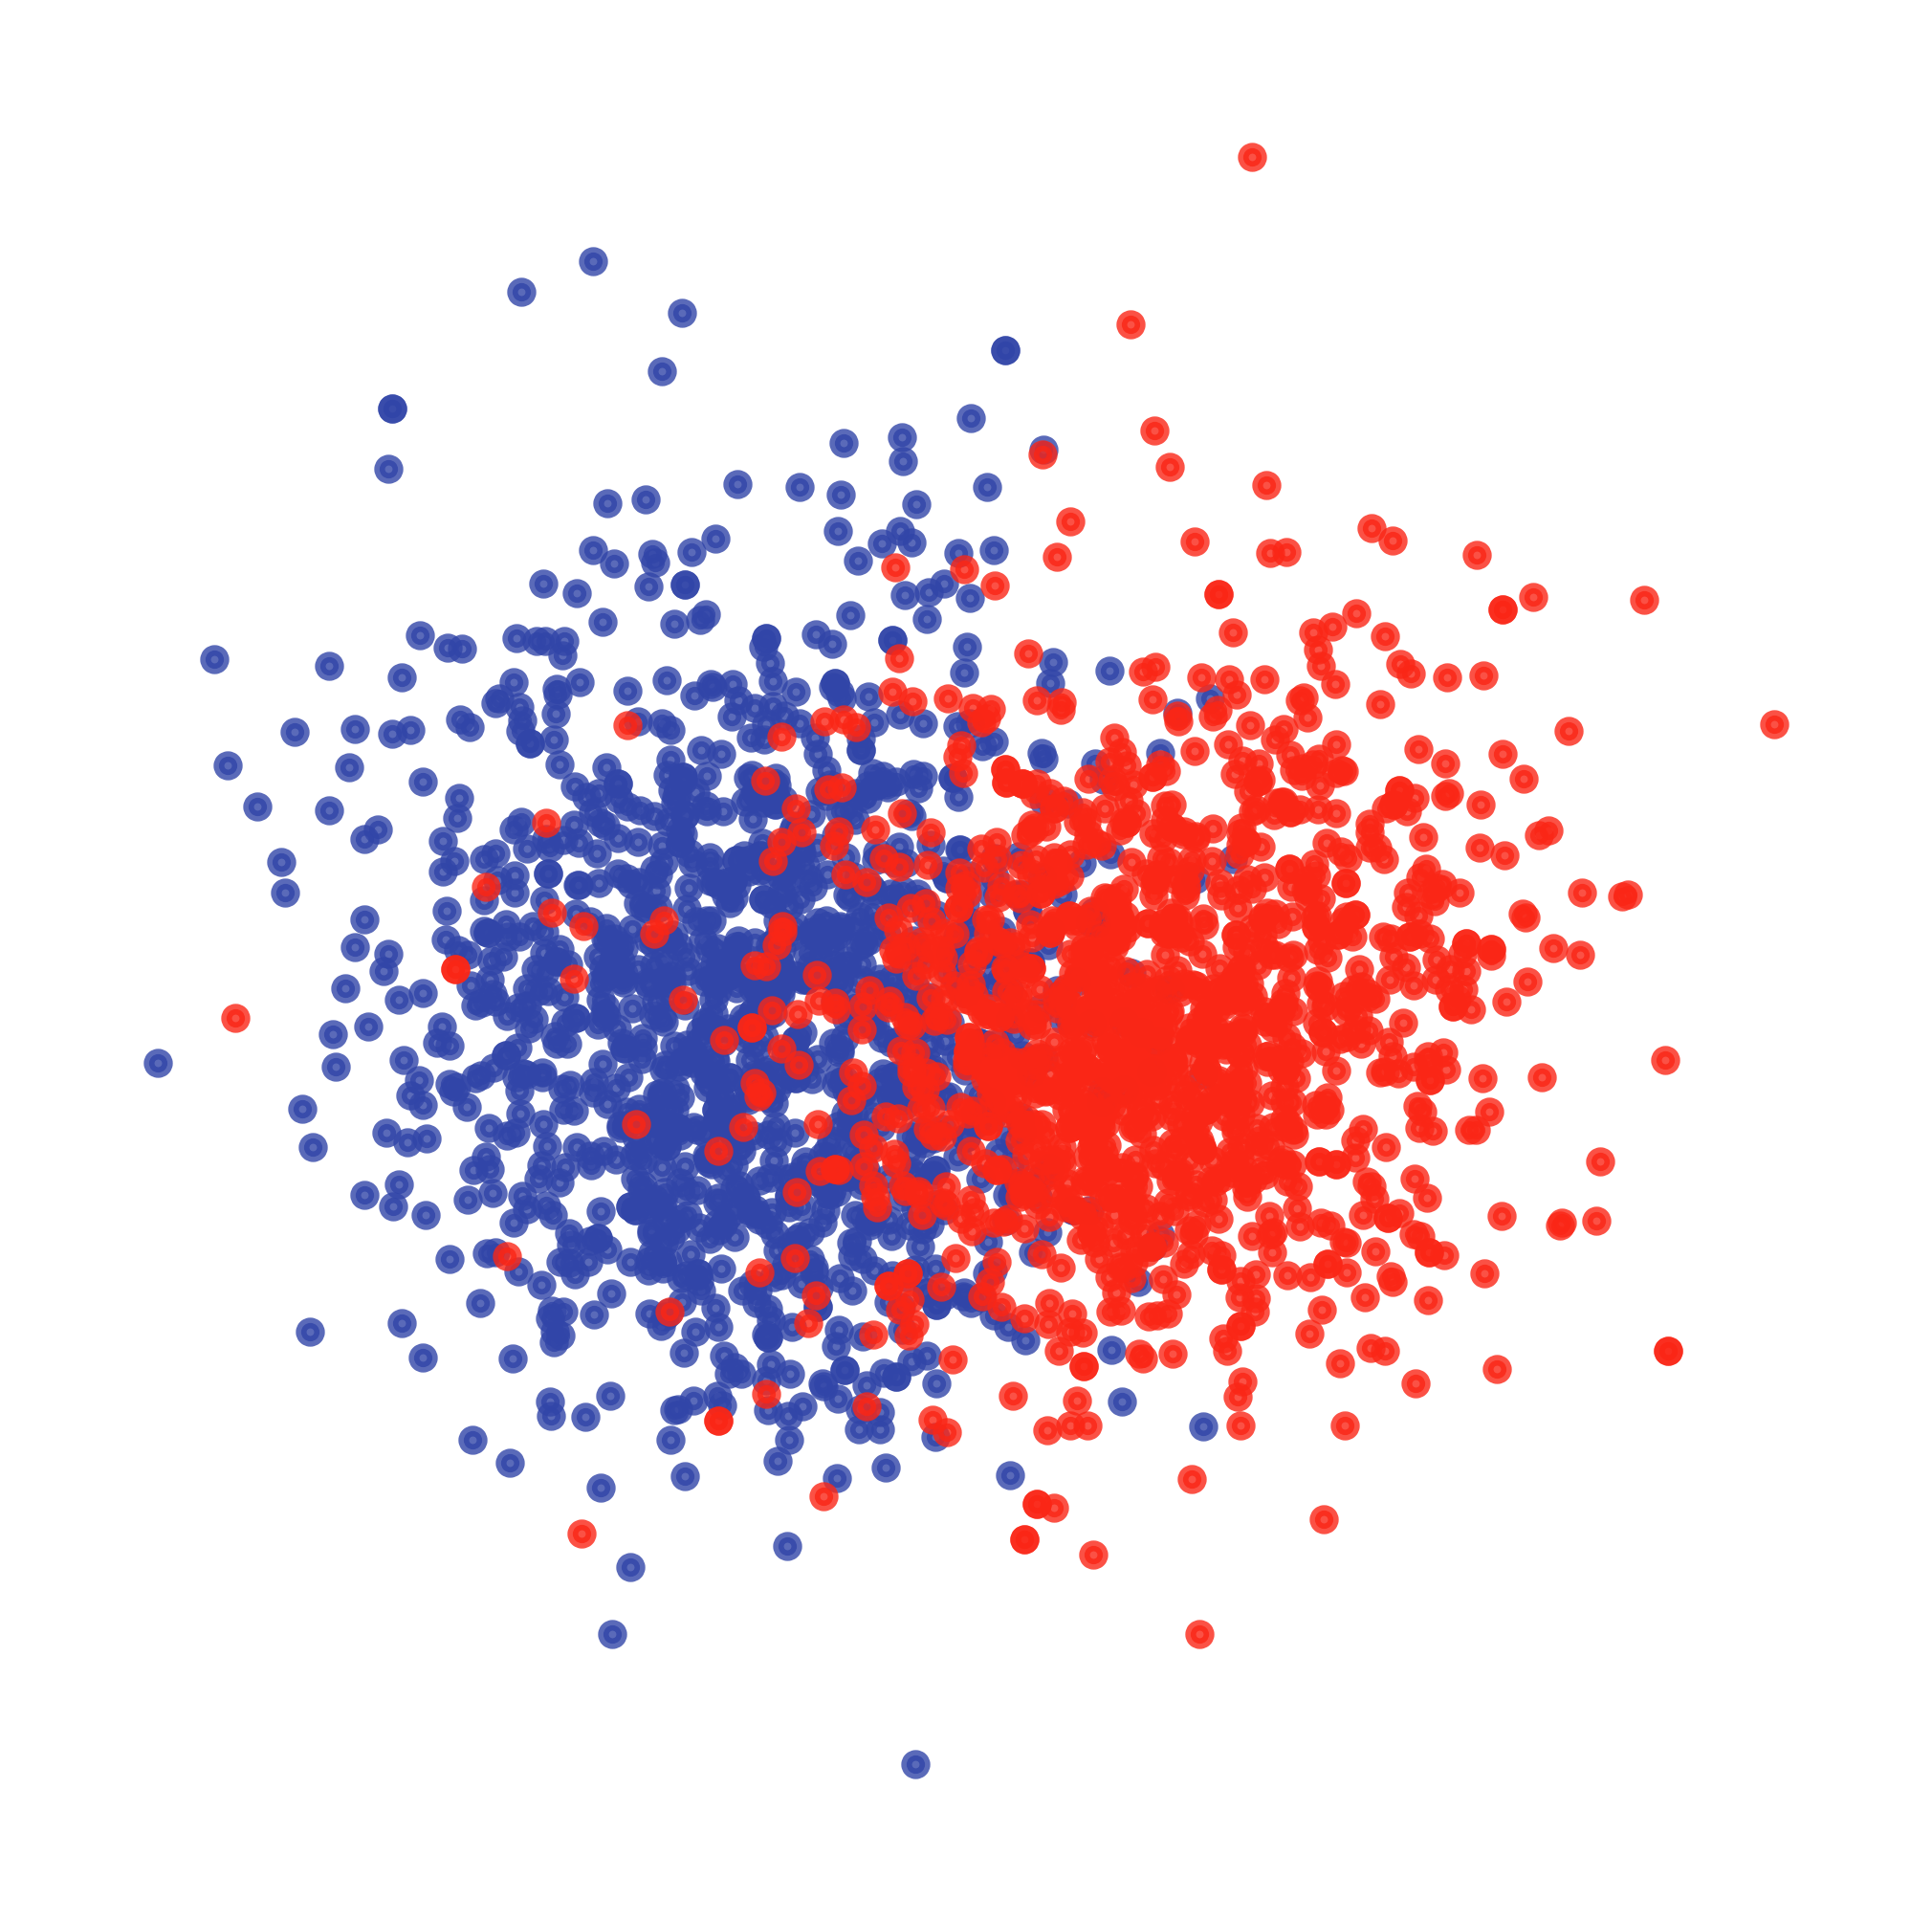

In [12]:
plot_util.plot_pca(x_T,
                   label = train_adata.obs['Group'],
                   size = 3, alpha=0.8,
                   colorlist = ['#3145a8', '#fa2616'],
                   color_label=[0,3]
                  )

## predict day 1-3 from day 0 and direction 

In [14]:
# get the day 0 vector from test data
z_sem = sampler.model.encoder(torch.tensor(train_adata.X).to('cuda'))
# get the represented differentiation latent vector  
direct_z_sem = z_sem[train_adata.obs.Group==3].mean(axis=0) - z_sem[train_adata.obs.Group==0].mean(axis=0)

In [44]:
test_adata = sc.read_h5ad('datasets/diff_test.h5ad')
z_sem_test_day0 = sampler.model.encoder(torch.tensor(test_adata[test_adata.obs['Group']==0].X).to('cuda'))
z_sem_test_day3 = sampler.model.encoder(torch.tensor(test_adata[test_adata.obs['Group']==3].X).to('cuda'))


In [82]:
r_all = []
pearsonr_all = []

for i in range(6):
    sample_interp0 = sampler.pred(z_sem = z_sem_test_day0,
                                  gene_size = 203,
                                 )
    sample_interp1 = sampler.interp_with_direction(z_sem_origin = z_sem_test_day0,
                                                   gene_size = 203,
                                                   direction = direct_z_sem,
                                                   scale = 1/3
                                                  )
    sample_interp2 = sampler.interp_with_direction(z_sem_origin = z_sem_test_day0,
                                                   gene_size = 203,
                                                   direction = direct_z_sem,
                                                   scale = 2/3
                                                  )
    sample_interp3 = sampler.pred(z_sem = z_sem_test_day3,
                                  gene_size = 203,
                                 )
    r2_, pearsonr_ = sampler.cal_metric(sample_interp0, test_adata[test_adata.obs['Group']==0])
    r_all.append(['squidiff',i,'day0',r2_])
    pearsonr_all.append(['squidiff',i,'day0',pearsonr_])
    r2_, pearsonr_ = sampler.cal_metric(sample_interp1, test_adata[test_adata.obs['Group']==1])
    r_all.append(['squidiff',i,'day1',r2_])
    pearsonr_all.append(['squidiff',i,'day1',pearsonr_])
    r2_, pearsonr_ = sampler.cal_metric(sample_interp2,  test_adata[test_adata.obs['Group']==2])
    r_all.append(['squidiff',i,'day2',r2_])
    pearsonr_all.append(['squidiff',i,'day2',pearsonr_])
    r2_, pearsonr_ = sampler.cal_metric(sample_interp3, test_adata[test_adata.obs['Group']==3])
    r_all.append(['squidiff',i,'day3',r2_])
    pearsonr_all.append(['squidiff',i,'day3',pearsonr_])
    
pd.DataFrame(r_all).to_csv('/hpc/mydata/siyu.he/Siyu_projects/Squidiff_reproducibility/fig2_diff_r_all_new.csv')
pd.DataFrame(pearsonr_all).to_csv('/hpc/mydata/siyu.he/Siyu_projects/Squidiff_reproducibility/fig2_diff_pearsonr_all_new.csv')


(0.7419393354022625, 0.9124766725309787)

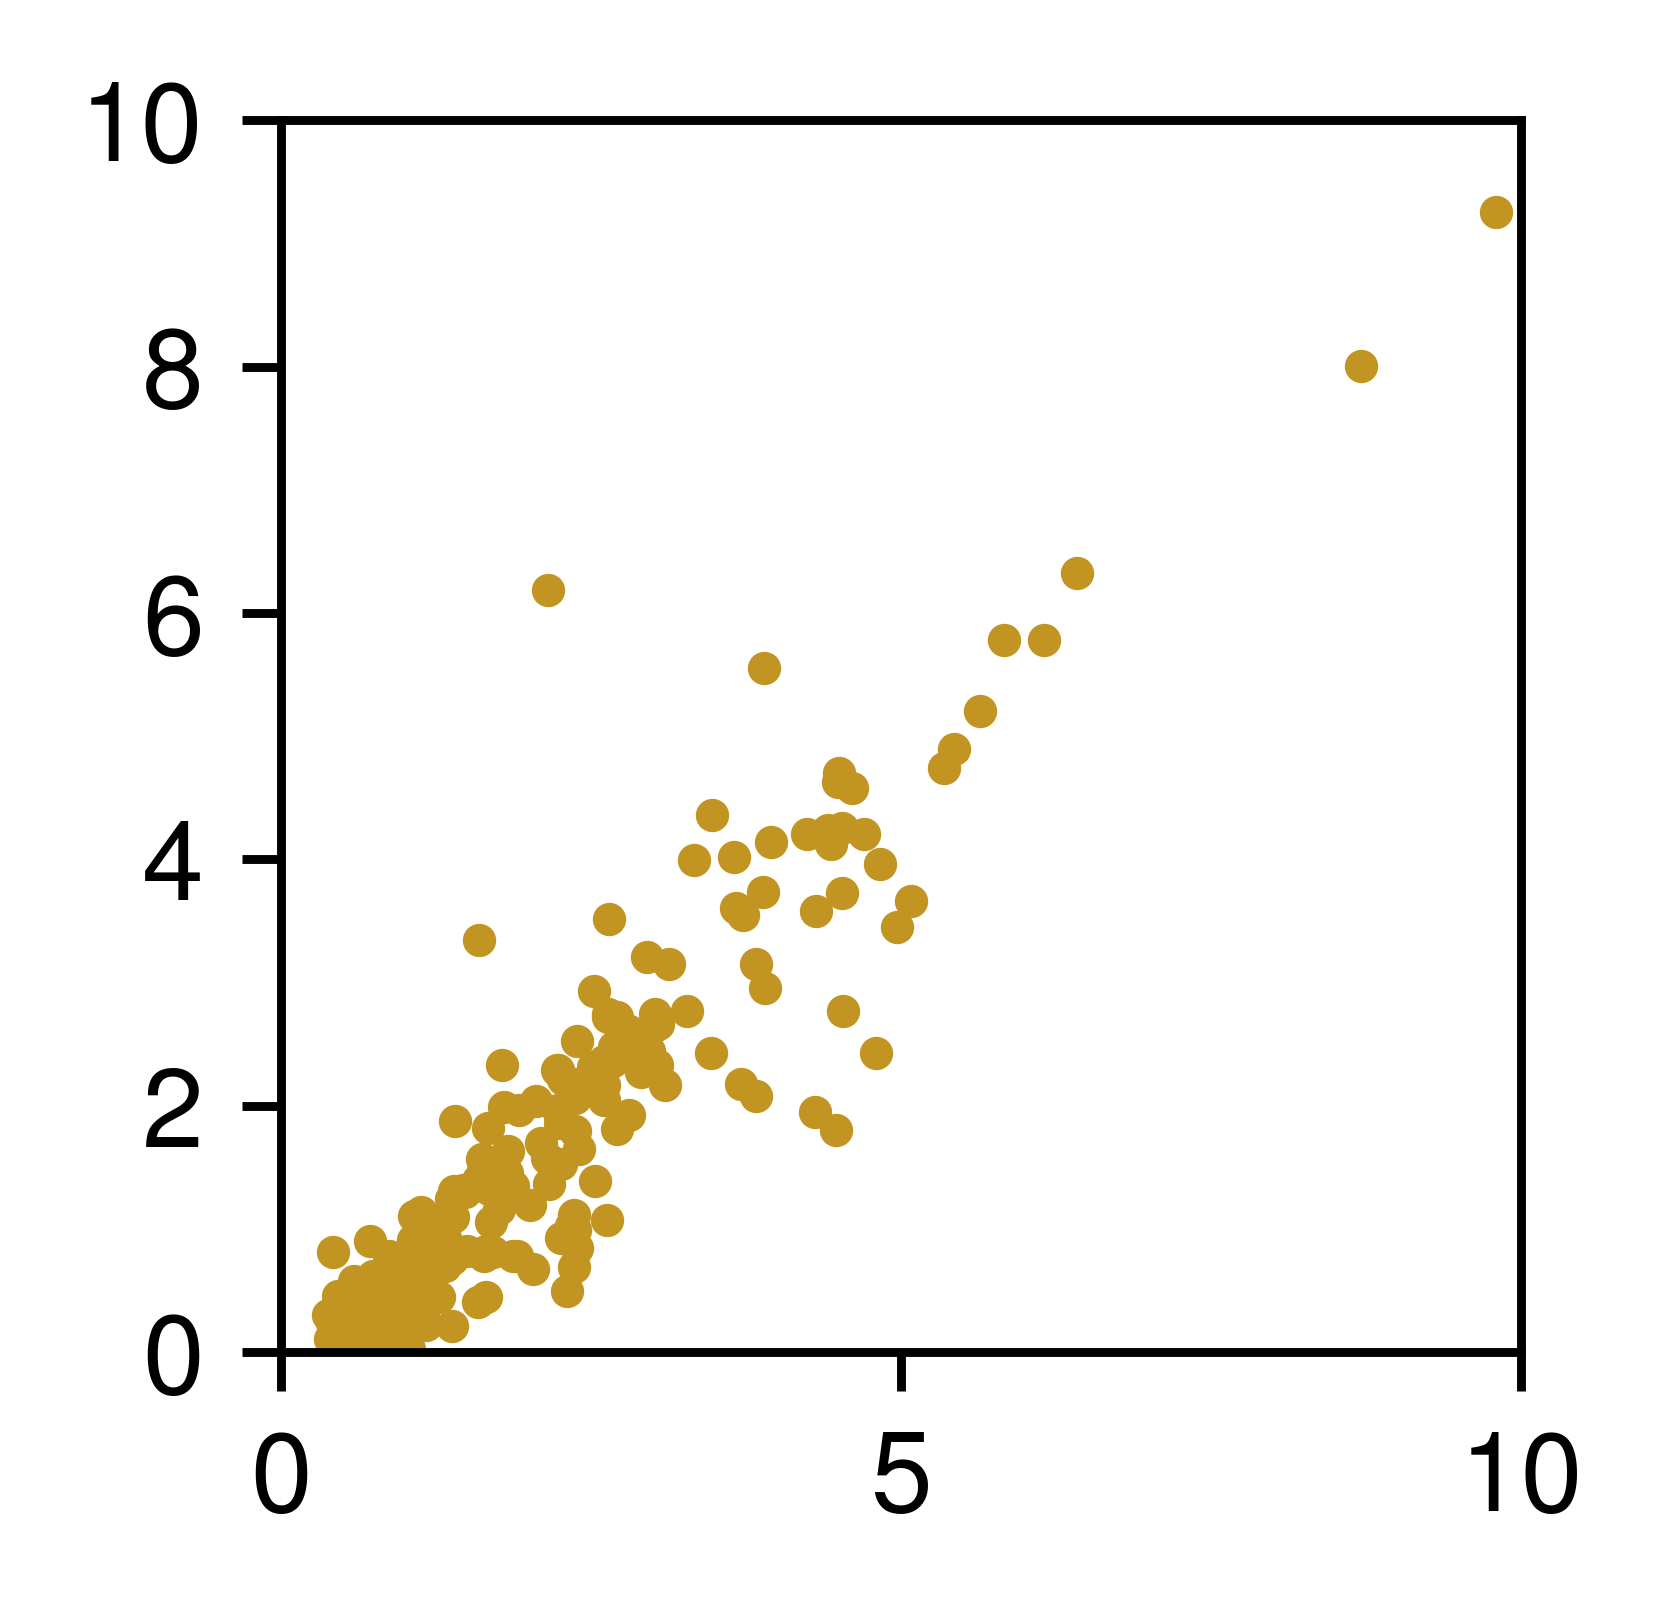

In [83]:
plt.subplots(1,1,figsize=(2,2),dpi=800)
plt.scatter(sample_interp2.detach().cpu().mean(axis=0),
            test_adata[test_adata.obs['Group']==2].X.mean(axis=0),
            s=4,
            c='#c29523'
           )
plt.xlim([0,10])
plt.ylim([0,10])

sampler.cal_metric(sample_interp2, test_adata[test_adata.obs['Group']==2])

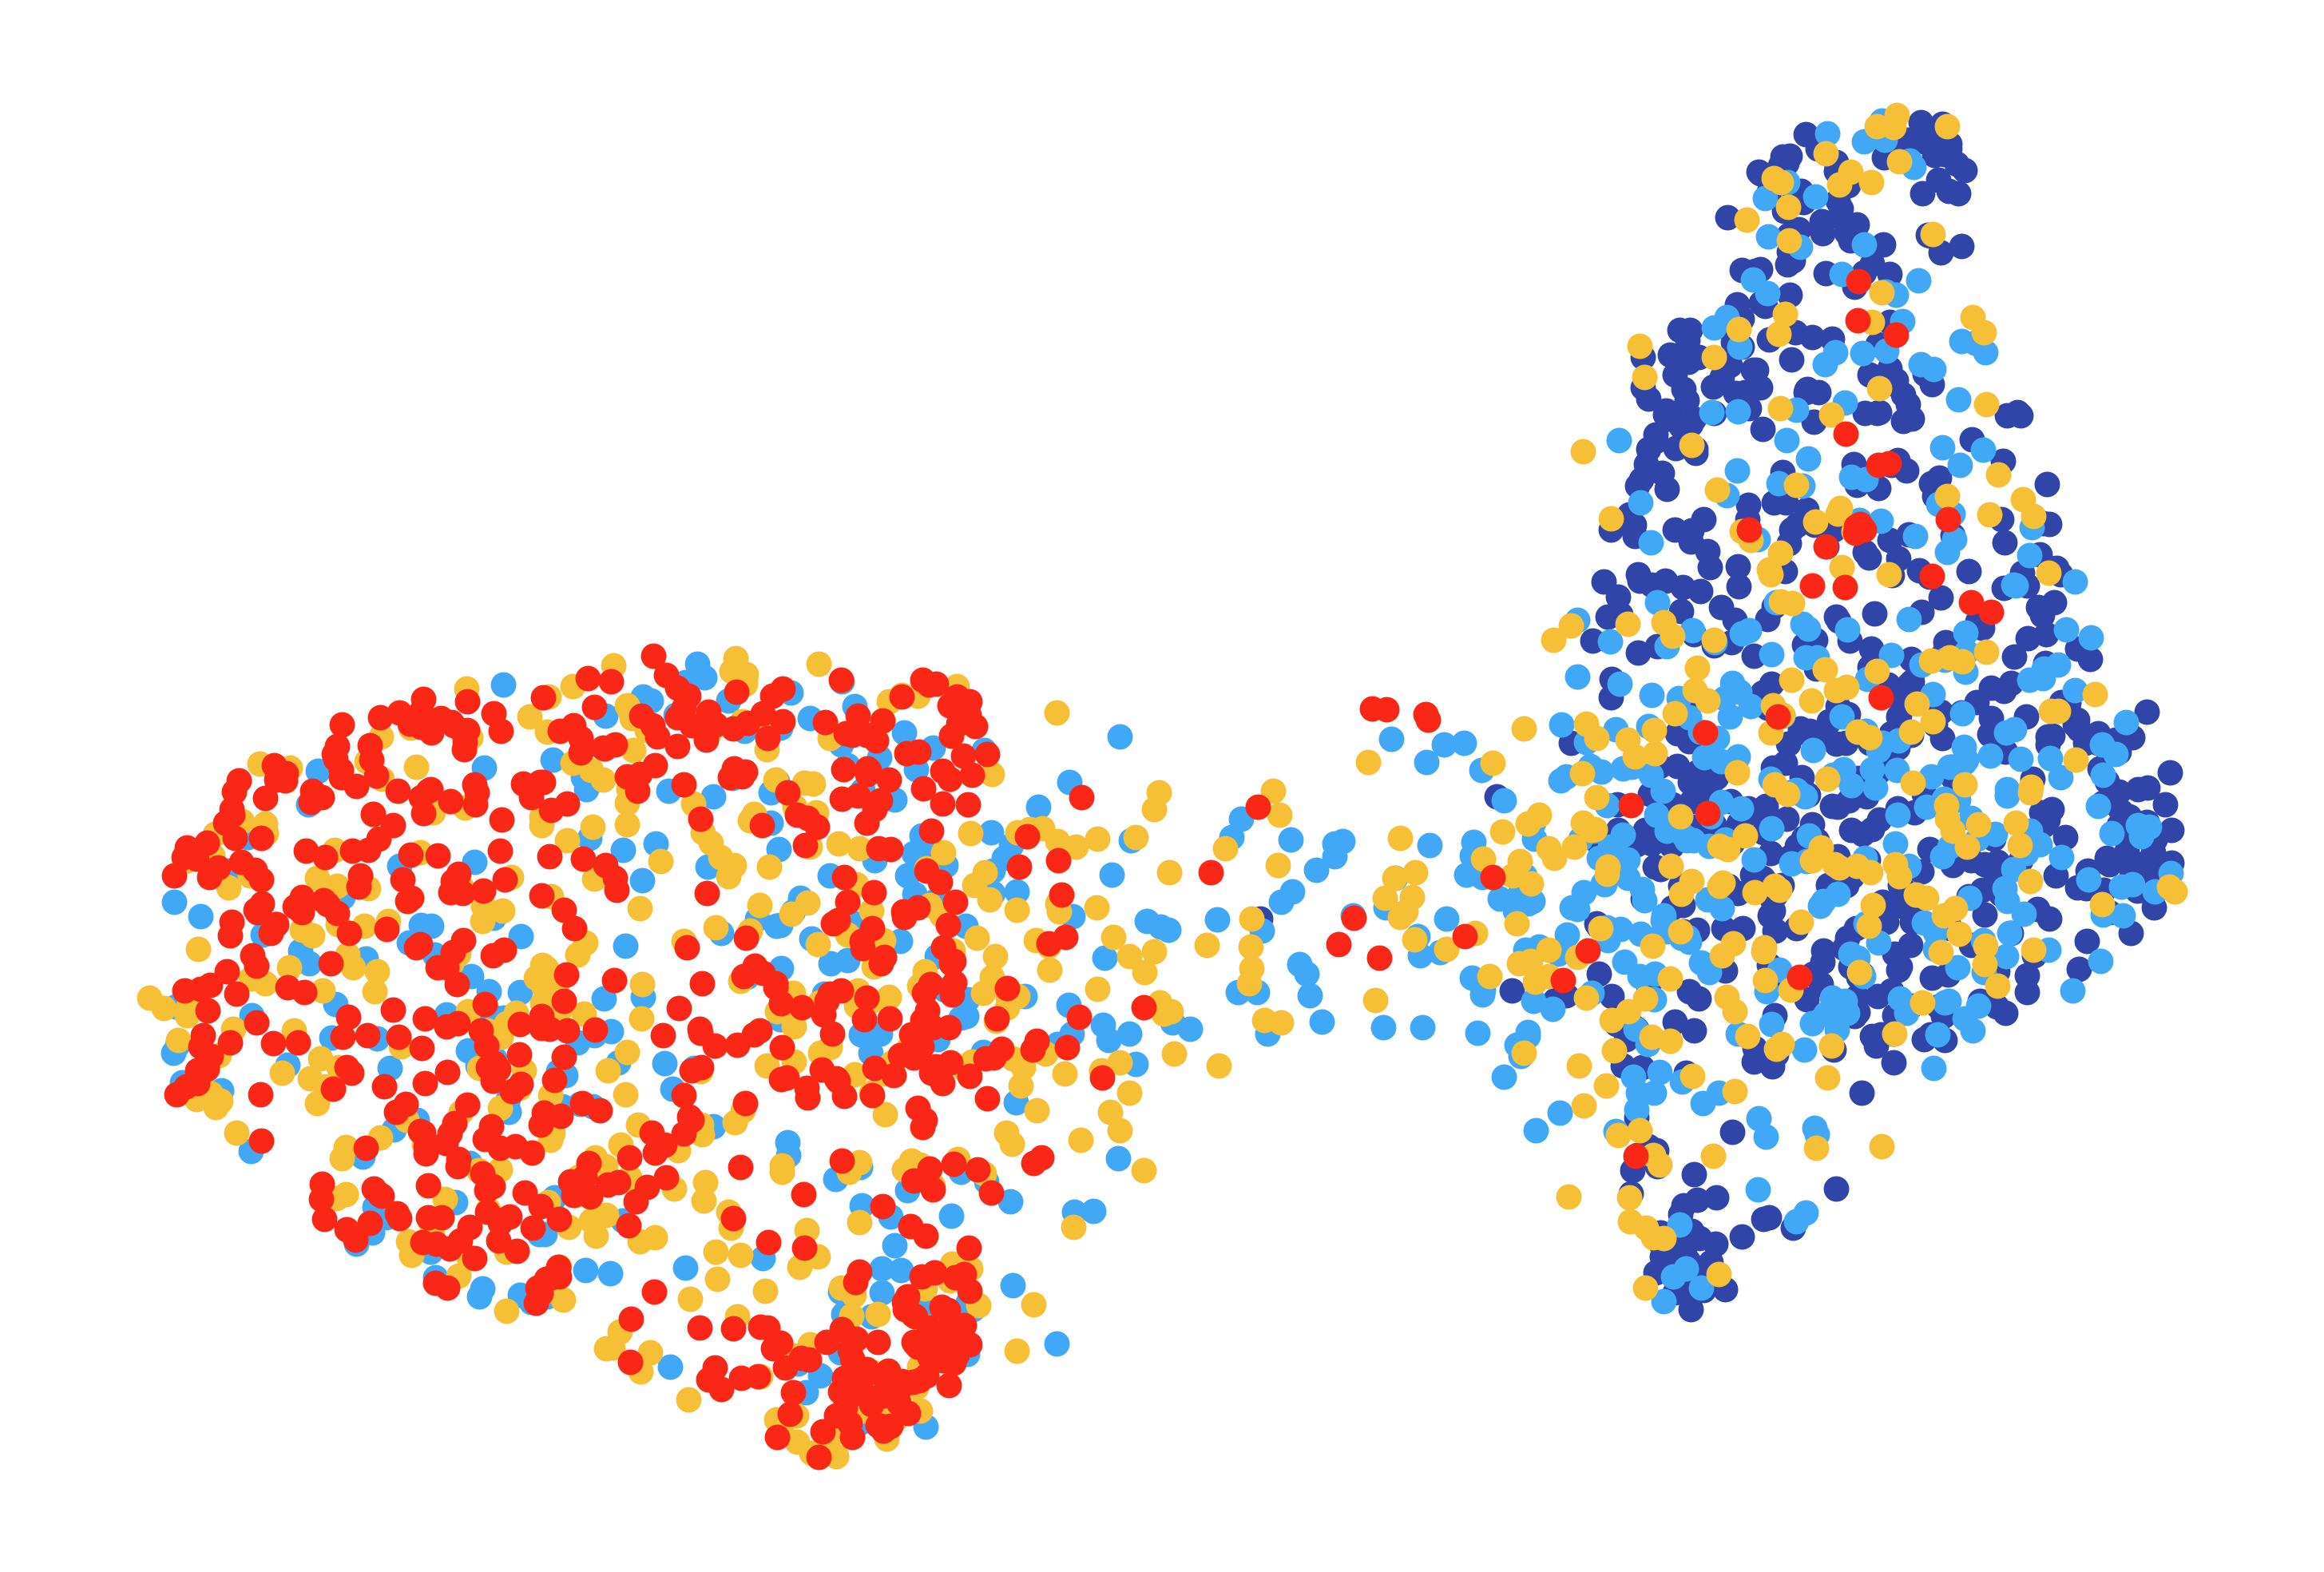

In [84]:
# Combine all points
from sklearn.decomposition import PCA
import umap
combined_points = np.concatenate([sample_interp0.detach().cpu().numpy(),
                                  sample_interp1.detach().cpu().numpy(),
                                  sample_interp2.detach().cpu().numpy(),
                                  sample_interp3.detach().cpu().numpy(),
                                 ], axis=0)
combined_labels  = np.array([0]*600+[1]*600+[2]*600+[3]*600)

pca = PCA(n_components=30)  # You can adjust the number of components
pca_result = pca.fit_transform(combined_points)
#pca_result

# Perform UMAP with increased neighbors
reducer = umap.UMAP(n_neighbors=50, min_dist=0.2, n_components=2)
embedding_combined = reducer.fit_transform(pca_result)

# Plotting
plt.figure(figsize=(6, 4), dpi=600)
colorlist = ['#3145a8', '#40a8f7', '#f5bf36', '#fa2616']  # Green and Magenta for interpolated points
for i in range(4):
    plt.scatter(embedding_combined[combined_labels == i, 0], 
                embedding_combined[combined_labels == i, 1], 
                c=colorlist[i], 
                s=8, 
                alpha=1)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.axis('off')
#plt.title('UMAP with Linear Interpolation between day0 and day3')
plt.show()


In [85]:
sampler.cal_metric(sample_interp0, test_adata[test_adata.obs['Group']==0])


(0.9963516276660932, 0.9982373476746477)

In [86]:
sampler.cal_metric(sample_interp1, test_adata[test_adata.obs['Group']==1])


(0.6544812131002518, 0.8645394346337459)

In [87]:
sampler.cal_metric(sample_interp2, test_adata[test_adata.obs['Group']==2])

(0.7419393354022625, 0.9124766725309787)

In [88]:
sampler.cal_metric(sample_interp3, test_adata[test_adata.obs['Group']==3])

(0.9929273146120354, 0.9970640393604692)

In [89]:
pred_tensor =np.array( torch.cat([sample_interp0,sample_interp1,sample_interp2,sample_interp3], dim=0).detach().cpu())
all_new_data = anndata.AnnData(pred_tensor)
all_new_data.obs['weights'] = combined_labels
all_new_data.obs['weights'] = all_new_data.obs['weights'].astype(str).astype('category')
all_new_data.var_names = test_adata.var_names

sc.tl.rank_genes_groups(all_new_data, groupby='weights', method='wilcoxon')
all_new_data.layers['scaled'] = sc.pp.scale(all_new_data, copy=True).X
marker_genes_dict = {
    '0.0': ['T', 'GATA6','NANOG'],
}

{'mainplot_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

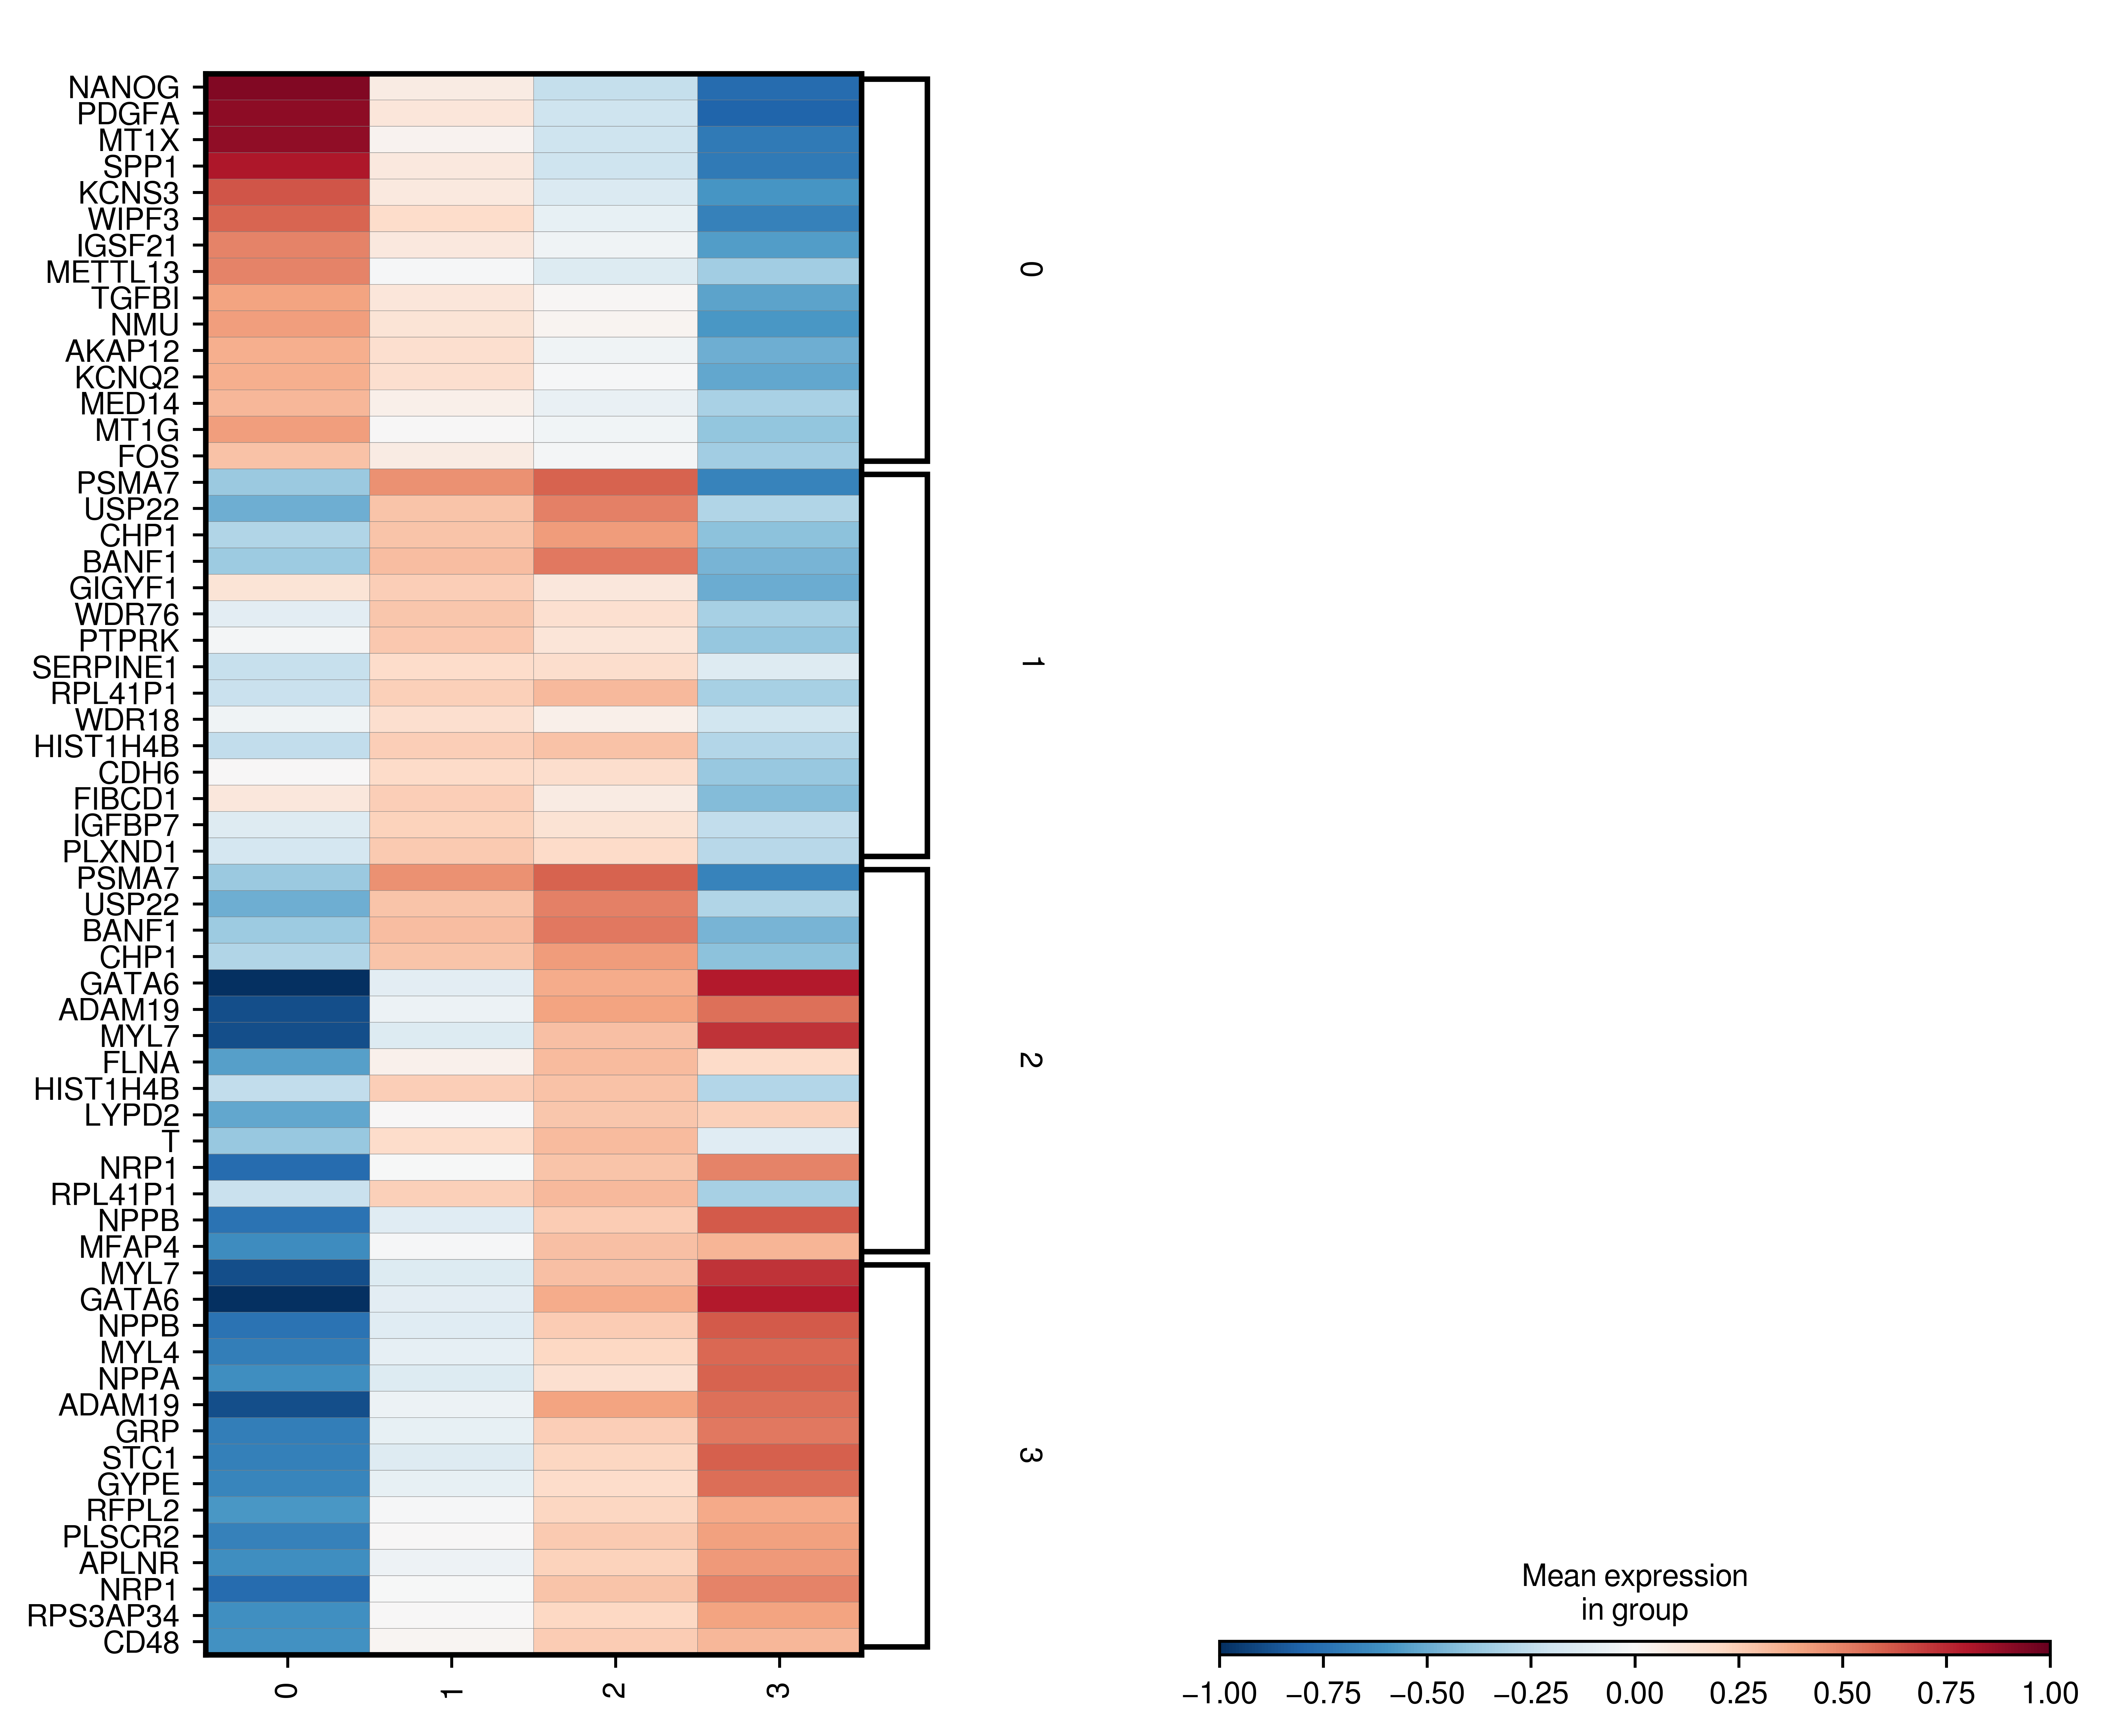

In [90]:
fig,ax = plt.subplots(figsize =(9,8),dpi=800)
sc.pl.rank_genes_groups_matrixplot(all_new_data, 
                                dendrogram=False,
                                n_genes=15, 
                                   use_raw=False, 
                                swap_axes=True, 
                                vmin=-1, vmax=1, 
                                cmap='RdBu_r', 
                                layer='scaled', 
                                   ax=ax,
                                show=False)

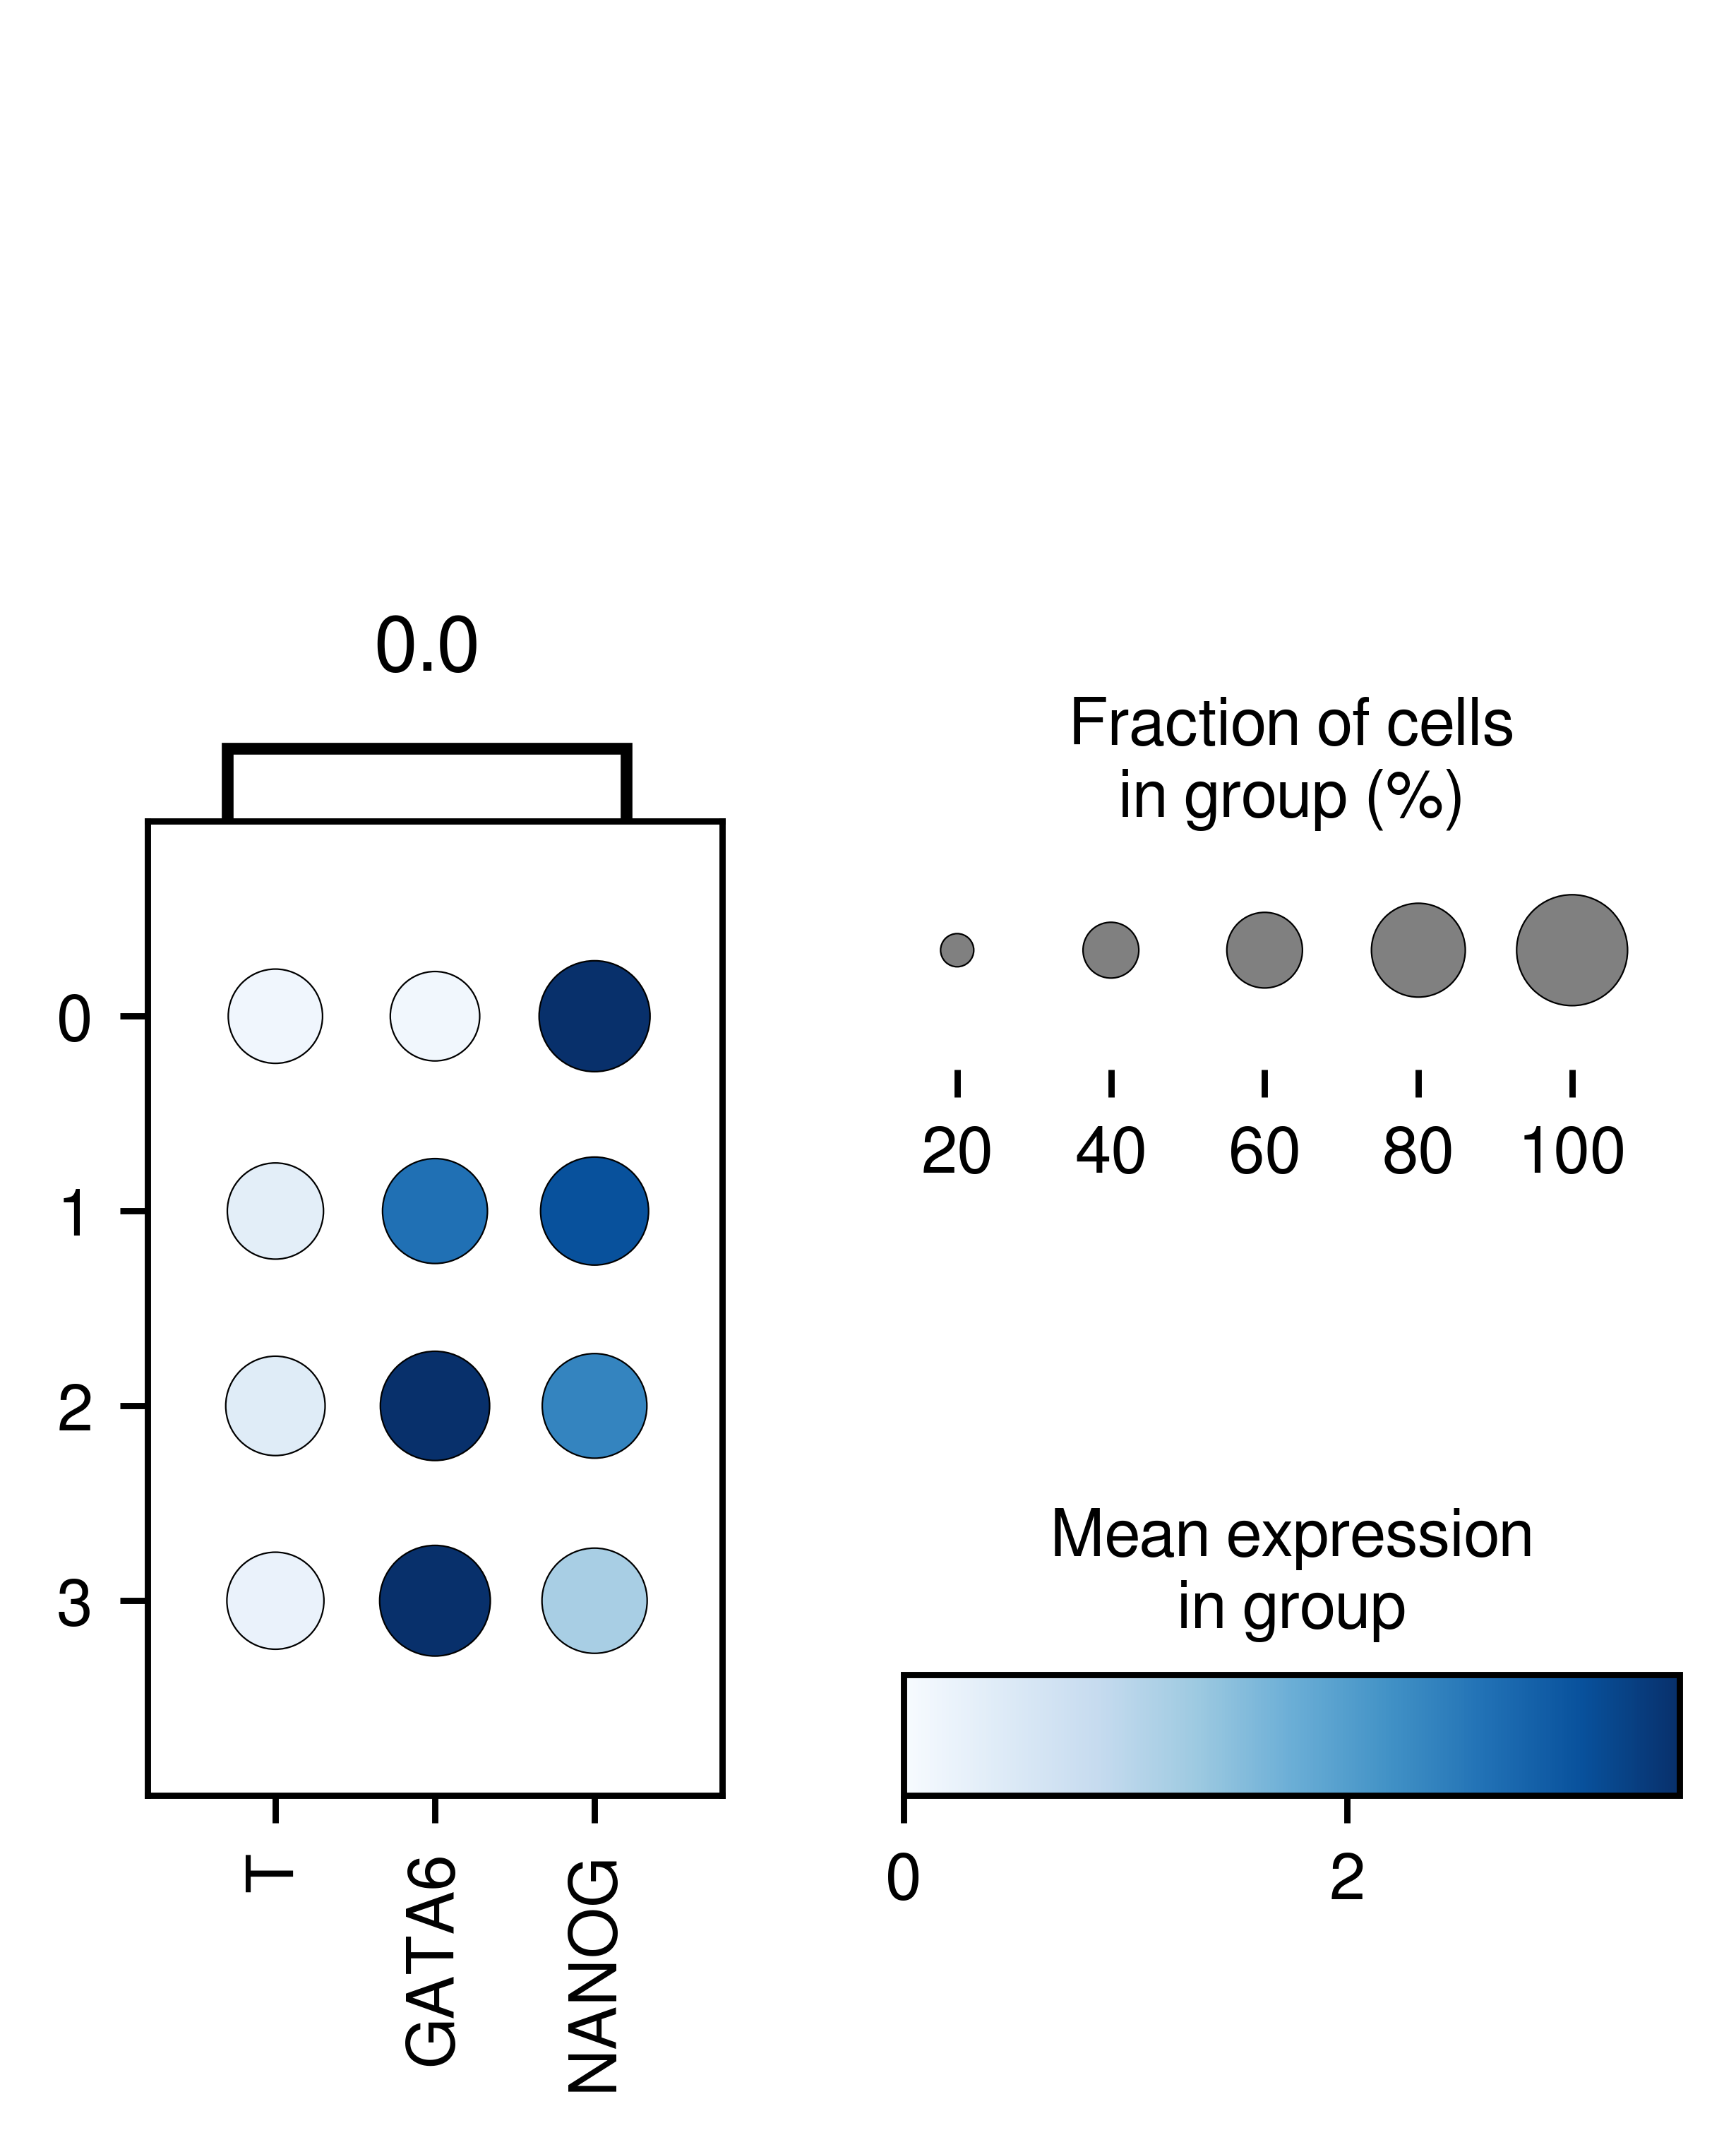

In [91]:
fig,ax = plt.subplots(figsize =(3.5,4),dpi=800)
sc.pl.dotplot(all_new_data, 
              marker_genes_dict, 'weights', 
              vmin=0,
              vmax=3.5,
              dendrogram=False,
              ax=ax,
              cmap='Blues',
             )

In [93]:
p_time = pd.read_csv('../Squidiff_project/figure2_dataset1_time_1022.csv',index_col=0)
all_new_data.obs['Pseudotime'] = p_time.values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


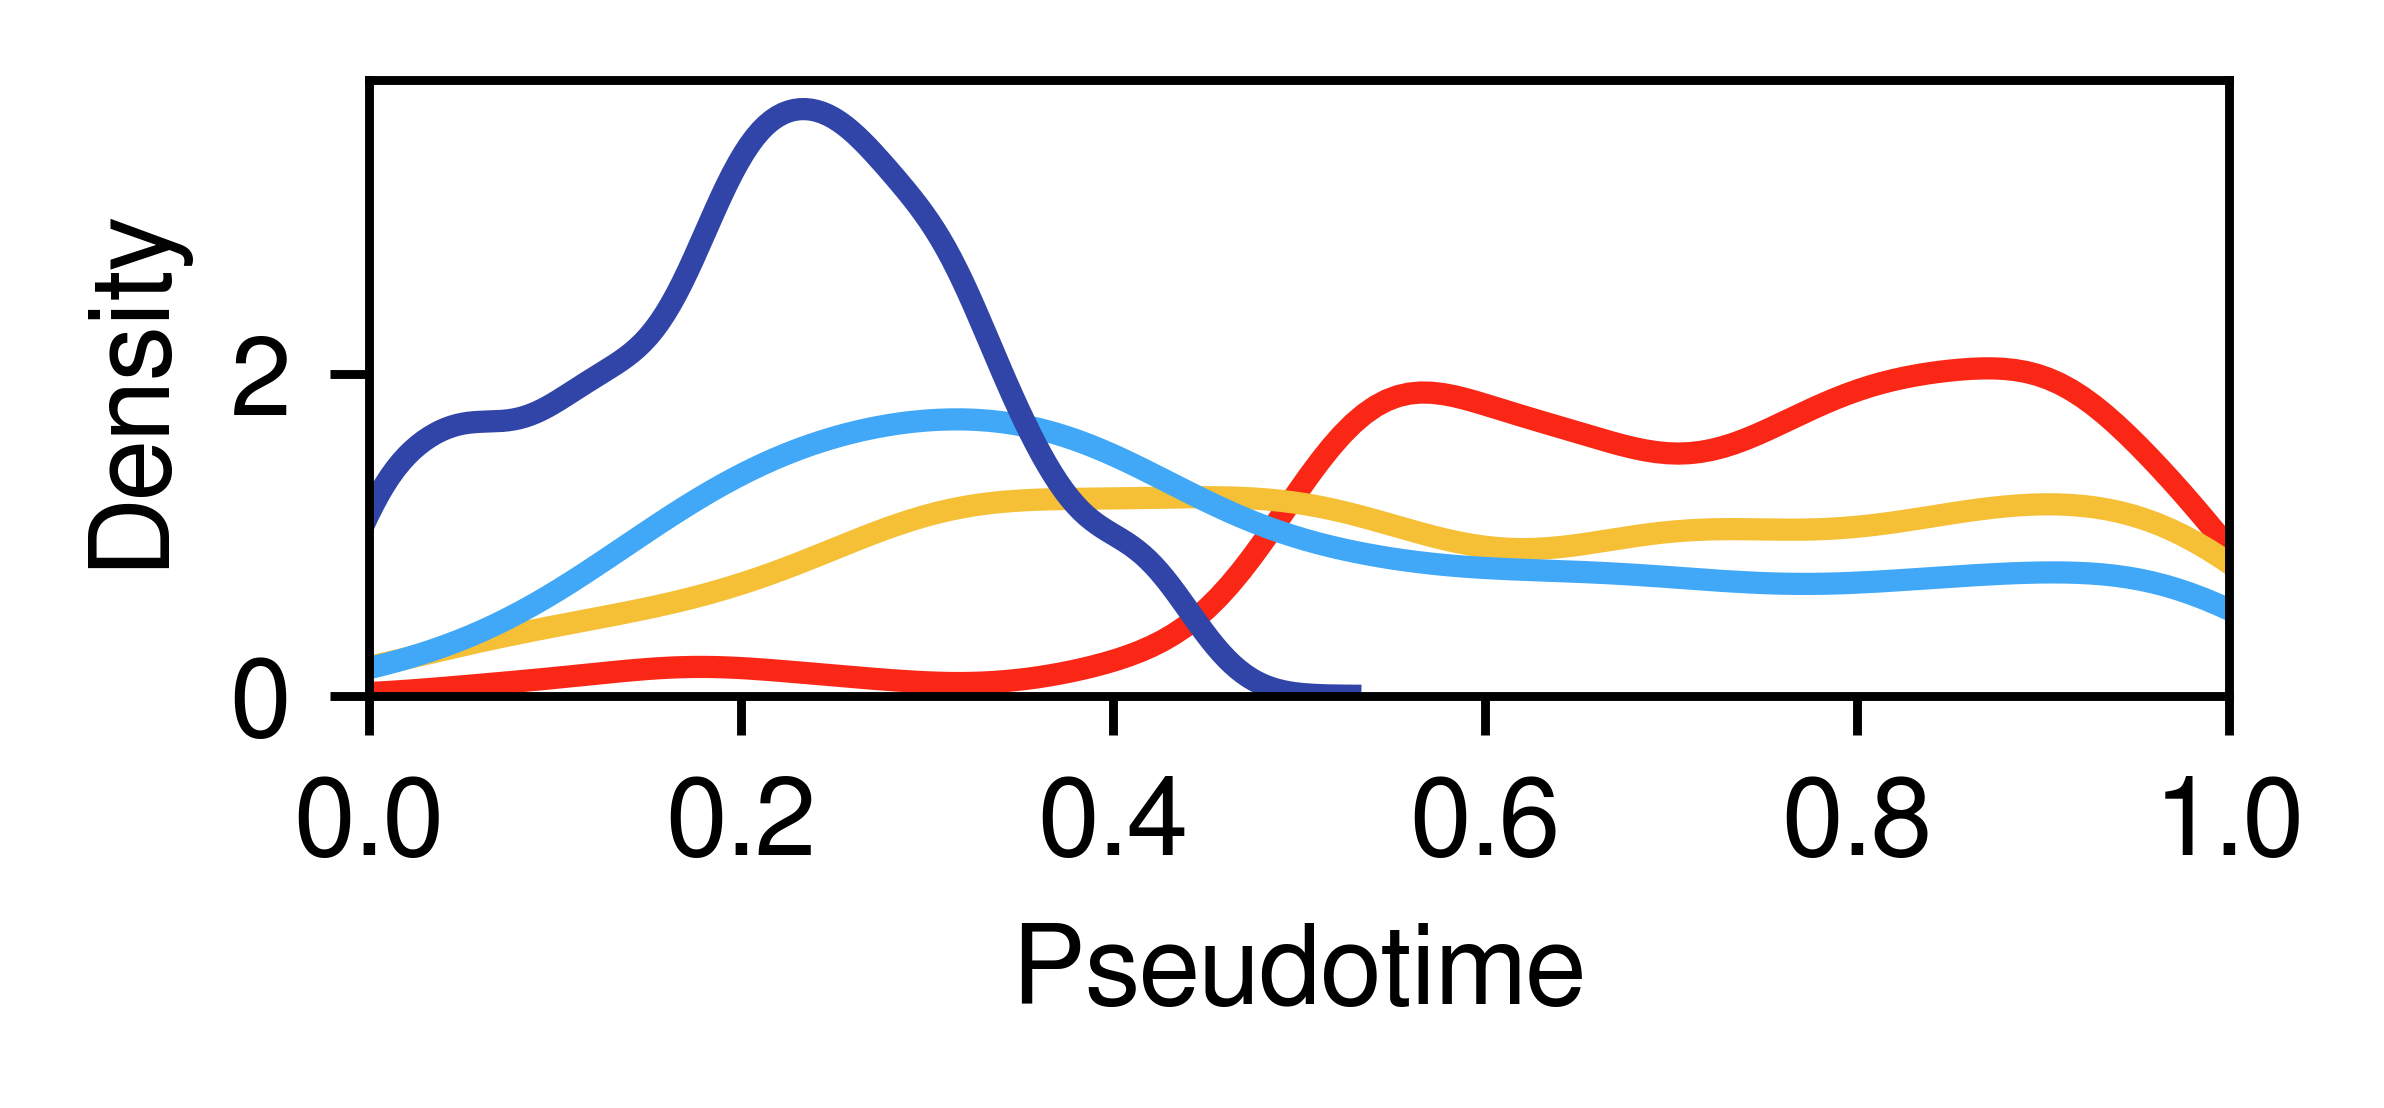

In [95]:
hex_colors = ['#3145a8', '#40a8f7', '#f5bf36','#fa2616']


plt.figure(figsize=(3,1
                   ),dpi=800)
sns.kdeplot(data=all_new_data.obs, 
            x="Pseudotime", 
            hue="weights", 
            bw_adjust=.8,
            palette=hex_colors,
            linewidth=2  ,  
            common_norm=False)
plt.legend().set_visible(False)
plt.xlabel("Pseudotime")
plt.ylabel("Density")
plt.xlim([0,1])
plt.show()